In [4]:
cd drive/MyDrive/Colab\ Notebooks/cells

/content/drive/MyDrive/Colab Notebooks/cells


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import mmread


class RNA(Dataset):
    def __init__(self, data_file):
        # load the scRNA-seq data from the specified file
        self.data = torch.from_numpy(
            mmread(data_file).astype("float32").transpose().todense())
        print(self.data.shape)
        
    def __len__(self):
        # return the number of examples in the dataset
        return len(self.data)
    
    def __getitem__(self, index):
        # return the preprocessed data for the specified example
        library = self.data[index].sum(dim=-1)
        example = self.data[index]
        return example, library

        

# datasets: hcl, celegan, uc_epi, zfish_ep50_5226
# train_dataset = RNA("cells/data/hcl.mtx")
# train_dataset = RNA("data/zfish_ep50_5226.mtx")
train_dataset = RNA("data/celegan.mtx")
train_loader = DataLoader(train_dataset, batch_size=2**12, shuffle=True) # 2**15


torch.Size([86024, 2766])


In [190]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim


class Encoder(nn.Module):
    def __init__(self, d, latent_dim):
        super(Encoder, self).__init__()
        self.fc0 = nn.Linear(in_features=d, out_features=d//2)
        self.fc1 = nn.Linear(in_features=d//2, out_features=d//4)
        self.fc2 = nn.Linear(in_features=d//4, out_features=d//8)
        self.fc3_mean = nn.Linear(in_features=d//8, out_features=latent_dim)
        self.fc3_var  = nn.Linear(in_features=d//8, out_features=latent_dim)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc3_mean(x)
        logvar = self.fc3_var(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, d, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=d//8)
        self.fc2 = nn.Linear(in_features=d//8, out_features=d//4)
        self.fc3 = nn.Linear(in_features=d//4, out_features=d//2)
        self.fc4 = nn.Linear(in_features=d//2, out_features=d)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class VAE(nn.Module):
    def __init__(self, d=2766, latent_dim=2, kl_weight=1):
        super(VAE, self).__init__()
        self.encoder = Encoder(d, latent_dim)
        self.decoder = Decoder(d, latent_dim)
        self.kl_weight = kl_weight

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x, library=None):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)

        if library is not None:
            recon = F.softmax(recon, dim=-1)
            recon = recon * library.unsqueeze(-1)
            
        return recon, mu, logvar

    def loss(self, x, recon, mu, logvar):
        mse = F.mse_loss(recon, x)
        kld = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        return mse, kld


dev = "cpu"    
model = VAE(d=next(iter(train_loader))[0].shape[-1], latent_dim=2).to(dev)
model.train()
opt = optim.Adam(model.parameters())

VAE(
  (encoder): Encoder(
    (fc0): Linear(in_features=2766, out_features=1383, bias=True)
    (fc1): Linear(in_features=1383, out_features=691, bias=True)
    (fc2): Linear(in_features=691, out_features=345, bias=True)
    (fc3_mean): Linear(in_features=345, out_features=2, bias=True)
    (fc3_var): Linear(in_features=345, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=345, bias=True)
    (fc2): Linear(in_features=345, out_features=691, bias=True)
    (fc3): Linear(in_features=691, out_features=1383, bias=True)
    (fc4): Linear(in_features=1383, out_features=2766, bias=True)
  )
)

In [336]:
# save model
# torch.save(model.state_dict(), "models/VAE.pt")
# model.load_state_dict(torch.load("VAE.pt"))

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D

class GMVAE(nn.Module):
    def __init__(self, in_size, x_size, hidden_size, K):
        super(GMVAE, self).__init__()
        self.in_size = in_size
        self.x_size = x_size
        self.hidden_size = hidden_size
        self.K = K
        
        # Encoder
        self.encStack = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU())
        
        self.fc_mu_z = nn.Linear(self.hidden_size, self.x_size)
        self.fc_logvar_z = nn.Linear(self.hidden_size, self.x_size)
        self.fc_mu_px = nn.ModuleList(
            [nn.Linear(self.hidden_size, self.x_size) for i in range(self.K)])
        self.fc_logvar_px = nn.ModuleList(
            [nn.Linear(self.hidden_size, self.x_size) for i in range(self.K)])
        
        # Decoder
        self.decStack = nn.Sequential(
            nn.Linear(self.x_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.in_size))
        
    def encode(self, x):
        h = self.encStack(x)
        mu_z = self.fc_mu_z(h)
        logvar_z = self.fc_logvar_z(h)
        z = self.reparameterize(mu_z, logvar_z)
        return mu_z, logvar_z, z
    
    def decode(self, z):
        h = self.decStack(z)
        mu_px = [fc(h) for fc in self.fc_mu_px]
        logvar_px = [fc(h) for fc in self.fc_logvar_px]
        return mu_px, logvar_px
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu_z, logvar_z, z = self.encode(x)
        mu_px, logvar_px = self.decode(z)
        p = [D.Normal(mu, torch.exp(0.5*logvar)) for mu, logvar in zip(mu_px, logvar_px)]
        p = [dist.rsample() for dist in p]
        return mu_z, logvar_z, mu_px, logvar_px, p

    def loss(self, x):
        mu_z, logvar_z, mu_px, logvar_px, p = self.forward(x)
        kl = self.kl_div(mu_z, logvar_z)
        kl = kl.sum(dim=1).mean()
        nll = self.neg_log_likelihood(x, mu_px, logvar_px, p)
        nll = nll.sum(dim=1).mean()
        loss = kl + nll
        return loss, kl, nll
    
    def kl_div(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)

    def neg_log_likelihood(self, x, mu, logvar, p):
        nll = []
        for i in range(self.K):
            dist = D.Normal(mu[i], torch.exp(0.5*logvar[i]))
            nll_i = -dist.log_prob(p[i])
            nll.append(nll_i)
        nll = torch.stack(nll, dim=1)
        return nll

    def train_step(self, x, optimizer):
        optimizer.zero_grad()
        loss, kl, nll = self.loss(x)
        loss.backward()
        optimizer.step()
        return loss, kl, nll




dev = "cpu"    
model = GMVAE(in_size=next(iter(train_loader))[0].shape[-1], x_size=2, hidden_size=256, K=5).to(dev)
model.train()
opt = optim.Adam(model.parameters())
model


GMVAE(
  (encStack): Sequential(
    (0): Linear(in_features=2766, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (fc_mu_z): Linear(in_features=256, out_features=2, bias=True)
  (fc_logvar_z): Linear(in_features=256, out_features=2, bias=True)
  (fc_mu_px): ModuleList(
    (0): Linear(in_features=256, out_features=2, bias=True)
    (1): Linear(in_features=256, out_features=2, bias=True)
    (2): Linear(in_features=256, out_features=2, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_logvar_px): ModuleList(
    (0): Linear(in_features=256, out_features=2, bias=True)
    (1): Linear(in_features=256, out_features=2, bias=True)
    (2): Linear(in_features=256, out_features=2, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=Tr

In [13]:
# train the GMVAE
for epoch in range(100):
    for batch in train_loader:
        loss, kl, nll = model.train_step(batch[0], opt)
    print(f"Epoch {epoch} | Loss: {loss:.3f} | KL: {kl:.3f} | NLL: {nll:.3f}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x2766 and 256x2)

In [7]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.distributions import Gumbel

# class GMVAE(nn.Module):
#     def __init__(self, input_dim, latent_dim, num_clusters):
#         super(GMVAE, self).__init__()
#         self.input_dim = input_dim
#         self.latent_dim = latent_dim
#         self.num_clusters = num_clusters
        
#         # Encoder network
#         self.encoder_fc1 = nn.Linear(input_dim, 2766)
#         self.encoder_fc2 = nn.Linear(2766, 512)
#         self.encoder_fc3 = nn.Linear(512, latent_dim * num_clusters * 2) # mu and log_var for each cluster
        
#         # Decoder network
#         self.decoder_fc1 = nn.Linear(latent_dim, 512)
#         self.decoder_fc2 = nn.Linear(512, 2766)
#         self.decoder_fc3 = nn.Linear(2766, input_dim)
        
#     def encode(self, x):
#         h = F.relu(self.encoder_fc1(x))
#         h = F.relu(self.encoder_fc2(h))
#         h = self.encoder_fc3(h)
#         h = h.view(-1, self.num_clusters, self.latent_dim * 2)
#         mu, log_var = torch.chunk(h, 2, dim=-1)
#         return mu, log_var
    
#     def sample_gumbel(self, shape, device):
#         u = torch.rand(shape).to(device)
#         return -torch.log(-torch.log(u + 1e-20) + 1e-20)
    
#     def gumbel_softmax_sample(self, logits, temperature, device):
#         y = logits + self.sample_gumbel(logits.size(), device)
#         return F.softmax(y / temperature, dim=-1)
    
#     def decode(self, z):
#         h = F.relu(self.decoder_fc1(z))
#         h = F.relu(self.decoder_fc2(h))
#         x_hat = F.softmax(self.decoder_fc3(h), dim=-1)
#         return x_hat
    
#     def forward(self, x, temperature=1.0):
#         # Encoding
#         mu, log_var = self.encode(x)
        
#         # Sampling from the Gumbel-Softmax distribution
#         gumbel_softmax_logits = (mu + self.sample_gumbel(mu.size(), device=x.device)) / temperature
#         z = self.gumbel_softmax_sample(gumbel_softmax_logits, temperature, device=x.device)
        
#         print(z.shape)
#         # Decoding
#         x_hat = self.decode(z)
        
#         return x_hat, mu, log_var, z, gumbel_softmax_logits

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

class GMVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_clusters):
        super(GMVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.K = num_clusters
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim*num_clusters*2)
        )
        
        self.decoder = self.decode = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)
        mu = mu.view(-1, self.K, self.latent_dim)
        log_var = log_var.view(-1, self.K, self.latent_dim)
        return mu, log_var

    def reparameterize(self, mu, log_var, temperature=1.0):
        eps = torch.randn_like(log_var)
        z = mu + torch.exp(log_var / 2) * eps
        # Use the Gumbel-Softmax trick to sample z
        gumbel_softmax_logits = (z.view(-1, self.K, self.latent_dim) / temperature).softmax(dim=-1)
        z = (gumbel_softmax_logits * z.view(-1, self.K, self.latent_dim)).sum(dim=1)
        return z, gumbel_softmax_logits


    def forward(self, x, temperature=1.0):
        x = x.view(-1, self.input_dim)
        mu, log_var = self.encode(x)
        z, gumbel_softmax_logits = self.reparameterize(mu, log_var, temperature=temperature)
        x_hat = self.decode(z)
        return x_hat, mu, log_var, z, gumbel_softmax_logits

    


# initialize the model
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = GMVAE(input_dim=next(iter(train_loader))[0].shape[-1], latent_dim=2, num_clusters=5).to(dev)
model.train()
opt = optim.Adam(model.parameters())
model

GMVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2766, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2766, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2766, bias=True)
  )
)

In [4]:
import torch.optim as optim
from tqdm import tqdm

def gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')

    # KL divergence loss
    kl_div = (torch.exp(log_var) + mu**2 - 1 - log_var).sum(dim=-1)
    kl_loss = torch.mean(torch.sum(gumbel_softmax_logits * kl_div.unsqueeze(-1), dim=-1))
    
    # Total loss
    loss = recon_loss + temperature * kl_loss
    
    return loss, recon_loss, kl_loss


def train(model, dataloader, num_epochs, lr=1e-3, weight_decay=1e-5, initial_temperature=1.0, final_temperature=0.5, device='cpu'): 
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_history = {'train_loss': [], 'recon_loss': [], 'kl_loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0

        # Compute the temperature for this epoch based on the linear annealing schedule
        temperature = max(initial_temperature - epoch * (initial_temperature - final_temperature) / (num_epochs - 1), final_temperature)
        for x, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", leave=False):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, log_var, z, gumbel_softmax_logits = model(x, temperature=temperature)
            loss, recon_loss, kl_loss = gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=temperature)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_recon_loss = running_recon_loss / len(dataloader.dataset)
        epoch_kl_loss = running_kl_loss / len(dataloader.dataset)

        loss_history['train_loss'].append(epoch_loss)
        loss_history['recon_loss'].append(epoch_recon_loss)
        loss_history['kl_loss'].append(epoch_kl_loss)
        tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Recon loss: {epoch_recon_loss:.4f} - KL loss: {epoch_kl_loss:.4f}")
    model.eval()
    
    return loss_history


In [ ]:
def train(model, dataloader, num_epochs, initial_temperature, final_temperature, lr, weight_decay, device):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        num_batches = 0
        for x, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            x = x.to(device)
            
            # Compute the temperature for this batch based on the linear annealing schedule
            temperature = max(initial_temperature - epoch * (initial_temperature - final_temperature) / (num_epochs - 1), final_temperature)
            
            optimizer.zero_grad()
            x_hat, mu, log_var, z, gumbel_softmax_logits = model(x, temperature=temperature)
            loss = gmvae_loss(x, x_hat, mu, log_var, z, gumbel_softmax_logits, temperature=temperature)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = train_loss / num_batches
        train_losses.append(avg_train_loss)
        print(f"Train loss: {avg_train_loss:.4f}")
    
    return train_losses


In [8]:
train(model, train_loader, num_epochs=10, initial_temperature=1.0, final_temperature=0.5, lr=1e-3, weight_decay=1e-5, device=dev)

Epoch 1/10 - Loss: 19944.1562 - Recon loss: 19944.1441 - KL loss: 0.0120


Epoch 2/10 - Loss: 14839.2559 - Recon loss: 14839.2231 - KL loss: 0.0347


Epoch 3/10 - Loss: 12810.9649 - Recon loss: 12810.9251 - KL loss: 0.0446


Epoch 4/10 - Loss: 10891.6065 - Recon loss: 10891.5533 - KL loss: 0.0638


Epoch 5/10 - Loss: 10246.4142 - Recon loss: 10246.3526 - KL loss: 0.0791


Epoch 6/10 - Loss: 9747.1350 - Recon loss: 9747.0628 - KL loss: 0.0998


Epoch 7/10 - Loss: 9325.3965 - Recon loss: 9325.3247 - KL loss: 0.1077


Epoch 8/10 - Loss: 8903.0704 - Recon loss: 8902.9997 - KL loss: 0.1156


Epoch 9/10 - Loss: 8427.9859 - Recon loss: 8427.9170 - KL loss: 0.1241


Epoch 10/10 - Loss: 8051.7168 - Recon loss: 8051.6488 - KL loss: 0.1358


{'train_loss': [19944.156183339823,
  14839.255899766162,
  12810.964850334281,
  10891.606483728377,
  10246.41416893832,
  9747.134962290684,
  9325.396527831259,
  8903.07036346007,
  8427.985908547324,
  8051.716794649967],
 'recon_loss': [19944.144131652214,
  14839.223124119977,
  12810.925122503966,
  10891.553337586023,
  10246.352569668057,
  9747.062762735544,
  9325.324684031673,
  8902.999656538892,
  8427.916994185489,
  8051.648832466085],
 'kl_loss': [0.01201444317102654,
  0.03467773777556333,
  0.04463148100436216,
  0.0637854906300506,
  0.07905883916774861,
  0.09983673322303876,
  0.10772955110546911,
  0.11564029441548981,
  0.12409323372420052,
  0.13582139896324355]}

In [9]:
# Calculate reconstruction loss on the complete dataset
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x_hat, mu, log_var, z, gumbel_softmax_logits = model(x.to(dev), temperature=1.0)
    loss = F.mse_loss(x_hat, x.to(dev), reduction='mean')
    print(f"Reconstruction loss: {loss.item():.4f}")

Reconstruction loss: 3.2486


In [10]:
x_hat, mu, log_var, z, gumbel_softmax_logits = model(x.to(dev), temperature=1.0)

x_hat[1].sum(), x[1].sum()

(tensor(169.2537, grad_fn=<SumBackward0>), tensor(156.))

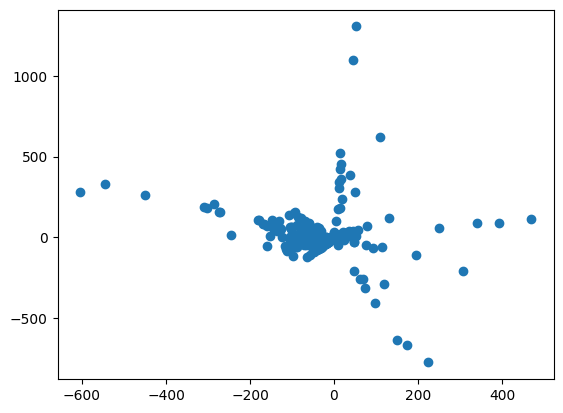

In [12]:
from matplotlib import pyplot as plt
# Latent representation of the data
model.eval()
with torch.no_grad():
    # x, _ = next(iter(train_loader))
    x_hat, mu, log_var, z, gumbel_softmax_logits = model(x.to(dev), temperature=1.0)
    z = z.cpu().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.show()

In [405]:
kl_weight = 0.5
num_epochs =25

# for each epoch
for epoch in range(num_epochs):
    # epoch losses
    mse_e, kld_e = 0, 0
    i = 0
  # for each data batch
    for x, lib in train_loader:
        x = x.to(dev)
        lib = lib.to(dev)

        opt.zero_grad()
        
        # vae
        # recon, mu, logvar = model(x, library=lib)
        # mse, kld = model.loss(x, recon, mu, logvar)
        # loss = mse + kl_weight * kld
        
        # gmvae
        mu_x, logvar_x, mu_px, logvar_px, qz, recon, mu_w, \
          logvar_w, x_sample = model(x, library=lib)
        
        loss, recon_loss, KLD_W, \
          KLD_Z, E_KLD_QX_PX, CV = loss_fn(recon, x, mu_w, logvar_w, qz,	mu_x, logvar_x, mu_px, logvar_px, x_sample, model.x_size, model.K)

        loss.backward()
        opt.step()
        
        mse_e += mse
        kld_e += kld
        i += 1

    print("Epoch: {}, MSE: {}, KLD: {}".format(epoch, 
                                               mse_e/i, 
                                               kld_e/i))





/tmp/ipykernel_68319/2985712173.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  qz = F.softmax(self.fc_qz(h1))


Epoch: 0, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 1, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 2, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 3, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 4, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 5, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 6, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 7, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 8, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 9, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 10, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 11, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 12, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 13, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 14, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 15, MSE: 3.8216352462768555, KLD: 0.9419548511505127
Epoch: 16, MSE: 3.8216352462768555, KLD: 0.9419548

In [205]:
# z = model.reparameterize(*model.encoder(test))

# for i in range(z.shape[1]):
#     model.decoder.zero_grad()
#     leaf = z[0].detach().requires_grad_()
#     out = model.decoder(z[0])[i]
#     out.retain_grad()
#     out.backward(retain_graph=True)
#     gene_gradients.append(out.grad.clone().detach())


# G = torch.stack(gene_gradients)

# G

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [161]:
# Updated 14/02/2023: 

from functorch import jacfwd, vmap

def jac(f, z):
    # composed with vmap for batched Jacobians
    return vmap(jacfwd(f))(z)

# gene "correlation" matrix C
def C_matrix(f, z, normalize=False):
    '''
    f:      model.decode: (b, m) -> (b, n) 
    z:      torch.tensor whose size = (b, m) (keep b low for memory)
    out:    torch.tensor whose size = (b, n, n)
    '''
    J = jac(f, z)

    # J @ J.T on batch 
    if normalize:
        return torch.bmm(J, J.transpose(1,2)) / J.norm(p=2, dim=2).unsqueeze(-1)
    else:
        return torch.bmm(J, J.transpose(1,2))



def jac_robust(f, z):
    # alternative jac if experiencing crashes 
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    return torch.autograd.functional.jvp(f, z, v=v)[1].view(batch_size, z_dim, -1).permute(0, 2, 1)


# jacrev: 1.45s
# jacfwd: 80-90ms 
# jvp:    85-92ms 
    # /J.norm(p=2, dim=2).unsqueeze(-1)
    # out = torch.einsum('nij,nik->njk', J, J) # J.T @ J, riem. metric 

In [52]:
# test = next(iter(DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=False)))
test = next(iter(DataLoader(train_dataset, batch_size=200, shuffle=False)))


In [57]:
model.reparameterize(model.encoder(test[0].to(dev)))

TypeError: GMVAE.reparameterize() missing 1 required positional argument: 'log_var'

In [54]:
# Latent representation of the data
z = model.encoder(test[0].to(dev)))

TypeError: GMVAE.reparameterize() takes from 3 to 4 positional arguments but 201 were given

In [53]:
z = model.reparameterize(*model.encoder(test))

z[0]

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list

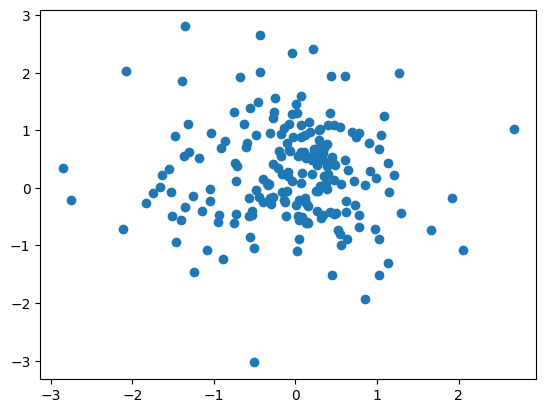

In [333]:
from matplotlib import pyplot as plt

zt = z.detach().numpy()


plt.scatter(zt[:,0], zt[:,1])

In [52]:
z = model.reparameterize(*model.encoder(test))

lim = 5
# j = JofD(model.decoder, z)[0]
# m1 = (j@ j.T) / j.norm(p=2, dim=1).unsqueeze(-1)


In [162]:
%%time
m2 = C_matrix(model.decoder, z[:lim])
m2.shape

(5, 2766, 2766)

torch.Size([5, 2766, 1])
CPU times: user 498 ms, sys: 366 ms, total: 863 ms
Wall time: 185 ms


(5, 2766, 2766)

In [100]:
z[0], z[1]

(tensor([0.9203, 0.4122], grad_fn=<SelectBackward0>),
 tensor([-0.3922,  0.7697], grad_fn=<SelectBackward0>))

## Trajectories

In [12]:
def get_Riemannian_metric(f, z, create_graph=False): #J.T @ J instead! 
    J = create_jac(f, z, create_graph=create_graph)
    out = torch.einsum('nij,nik->njk', J, J)
    return out


In [13]:
def compute_geodesic(z1, z2, pretrained_model, get_Riemannian_metric, num_discretization=100):
    '''
    z1 : torch.tensor whose size = (1, 2)
    z1 : torch.tensor whose size = (1, 2)
    out: torch.tensor whose size = (num_discretization, 2)
    '''
    from scipy.optimize import minimize
    class GeodesicFittingTool():
        def __init__(self, z1, z2, z_init, pretrained_model, get_Riemannian_metric, num_discretization, method, device=f"cuda:{0}"):
            self.z1 = z1
            self.z2 = z2
            self.pretrained_model = pretrained_model
            self.get_Riemannian_metric = get_Riemannian_metric
            self.num_discretization = num_discretization
            self.delta_t = 1/(num_discretization-1)
            self.device = device
            self.method = method
            self.z_init_input = z_init
            self.initialize()
            
        def initialize(self):
            self.z_init= self.z1.squeeze(0)
            self.z_final= self.z2.squeeze(0)
            dim = self.z_final.size(0)
            self.init_z = self.z_init_input.detach().cpu().numpy()
            self.z_shape = self.init_z.shape
            self.init_z_vec = self.init_z.flatten()

        def geodesic_loss(self, z): 
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1])
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            return loss.item()
        
        def jac(self, z):
            z_torch = torch.tensor(z.reshape(self.z_shape), dtype=torch.float32).to(self.device)
            z_torch.requires_grad = True
            z_extended = torch.cat([self.z_init.unsqueeze(0), z_torch, self.z_final.unsqueeze(0)], dim=0)
            G_ = self.get_Riemannian_metric(self.pretrained_model.decode, z_extended[:-1], create_graph=True)
            delta_z = (z_extended[1:, :]-z_extended[:-1, :])/(self.delta_t)
            loss = torch.einsum('ni, nij, nj -> ', delta_z, G_, delta_z) * self.delta_t
            loss.backward()
            z_grad = z_torch.grad
            return z_grad.detach().cpu().numpy().flatten()

        def callback(self, z):
            self.Nfeval += 1
            return print('{} th loss : {}'.format(self.Nfeval, self.geodesic_loss(z)))
            
        def BFGS_optimizer(self, callback=False, maxiter=1000):
            self.Nfeval = 0
            z0 = self.init_z_vec
            if callback == True:
                call = self.callback
            else:
                call = None
            res = minimize(
                self.geodesic_loss, 
                z0, 
                callback=call, 
                method=self.method,
                jac = self.jac,
                options = {
                    'gtol': 1e-10, 
                    'eps': 1.4901161193847656e-08, 
                    'maxiter': maxiter, 
                    'disp': True, 
                    'return_all': False, 
                    'finite_diff_rel_step': None}
                )
            self.res = res

    z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)
    
    tool = GeodesicFittingTool(z1, z2, z12_linear_curve[1:-1], pretrained_model, get_Riemannian_metric, num_discretization, 'BFGS', device=device)
    tool.BFGS_optimizer()
    z_torch = torch.tensor(tool.res['x'].reshape(tool.z_shape), dtype=torch.float32).to(device)
    out = torch.cat([tool.z_init.unsqueeze(0), z_torch, tool.z_final.unsqueeze(0)], dim=0)
    return out


In [ ]:
z1 = torch.tensor([[-1, 1]], dtype=torch.float32) 
z2 = torch.tensor([[0.6, -1.2]], dtype=torch.float32) 

num_discretization = 100
z12_geodesic_curve = compute_geodesic(
    z1.to(device), 
    z2.to(device), 
    pretrained_model, 
    get_Riemannian_metric, 
    num_discretization=num_discretization
)
assert z12_geodesic_curve.size() == torch.Size([num_discretization, 2])


In [ ]:
L12 = compute_length_of_curve(
    z12_geodesic_curve, pretrained_model, get_Riemannian_metric)
L12


In [ ]:
z12_linear_curve = torch.cat([z1.to(device) + (z2.to(device) - z1.to(device)) * t/(num_discretization-1) for t in range(num_discretization)], dim=0)

latent_embeddings = pretrained_model.encode(
    train_ds.data.to(device)
    ).detach().cpu().numpy()

z_scale = np.minimum(
    np.max(latent_embeddings, axis=0), 
    np.min(latent_embeddings, axis=0)
)
labels = torch.unique(train_ds.targets)

f = plt.figure(figsize=(7, 7))
plt.title('Latent space embeddings')
for label in labels:
    classwise_le = latent_embeddings[train_ds.targets == label]
    plt.scatter(
        classwise_le[:200, 0], 
        classwise_le[:200, 1], 
        label=label.item(), s=5)

plt.scatter(z1[0, 0], z1[0, 1], c='tab:red', marker='s')
plt.scatter(z2[0, 0], z2[0, 1], c='tab:green', marker='s')

plt.scatter(z12_linear_curve[:, 0].detach().cpu(), z12_linear_curve[:, 1].detach().cpu(), s=10, c='tab:gray')
plt.scatter(z12_geodesic_curve[:, 0].detach().cpu(), z12_geodesic_curve[:, 1].detach().cpu(), s=10, c='tab:pink')

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.legend()
plt.show()
